In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt 
import pymssql
# import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator

2022-08-04 16:54:59.663761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-04 16:54:59.663834: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def get_data():
    df=pd.DataFrame()
    try:
        con = pymssql.connect(user='ds_rcm',password = 'mtbc@123'
                     ,host='172.16.0.32',database='mis_db',autocommit = True)
    except Exception as e:
        print('unable to make connection',e)
    cur=con.cursor()

    query = """
    
SELECT CONVERT(date, CP.DATE_ENTRY) as Date, COUNT(DISTINCT C.CLAIM_NO) as Claims,
        SUM(CP.AMOUNT_PAID)'PAYMENTS'
        FROM PATIENT AS P
        JOIN CLAIMS AS C ON P.PATIENT_ACCOUNT=C.PATIENT_ACCOUNT

AND ISNULL(C.DELETED,0)=0
        AND ISNULL(P.DELETED,0)=0
        JOIN CLAIM_PAYMENTS AS CP ON C.CLAIM_NO=CP.CLAIM_NO
        AND ISNULL(CP.DELETED,0)=0
        JOIN PRACTICES AS PR ON PR.PRACTICE_CODE=P.PRACTICE_CODE
        AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
        AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
        AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
        AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
        WHERE CONVERT(date, CP.DATE_ENTRY) BETWEEN  CONVERT(date, '01-01-2019')
        AND CONVERT(date, '06-30-2022')
        GROUP BY CONVERT(date, CP.DATE_ENTRY)
        ORDER BY CONVERT(date, CP.DATE_ENTRY) ASC
        """
    try:
        cur.execute(query)
        df=pd.DataFrame(cur.fetchall(),columns=[x[0] for x in cur.description])
#         print(df)
#         df.columns=df.columns.str.upper()
        con.close()
    except:
        print('Error in reading data.....')
        con.close()
    return df

In [3]:
# claims = get_data()

In [4]:
# claims.to_csv('Payments_Data.csv')

In [5]:
claims = pd.read_csv('Payments_Data.csv')

In [40]:
print(claims.describe())

             Claims
count   1277.000000
mean   23447.789350
std    10420.545476
min      245.000000
25%    17938.000000
50%    24631.000000
75%    30368.000000
max    63022.000000


In [41]:
claims.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1277 entries, 2019-01-01 to 2022-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Claims  1277 non-null   int64
dtypes: int64(1)
memory usage: 52.2 KB


In [7]:
claims = claims[["Date", "Claims"]]

In [8]:
claims.head()

,Date,Claims
0,2019-01-01,16033
1,2019-01-02,25676
2,2019-01-03,31454
3,2019-01-04,33033
4,2019-01-05,9752


In [9]:
claims.isnull().sum()

Date      0
Claims    0
dtype: int64

In [10]:
len(claims)

1277

In [11]:
claims["Date"] = pd.to_datetime(claims["Date"])
claims = claims.sort_values('Date')
claims =claims.set_index("Date")

<AxesSubplot:xlabel='Date'>

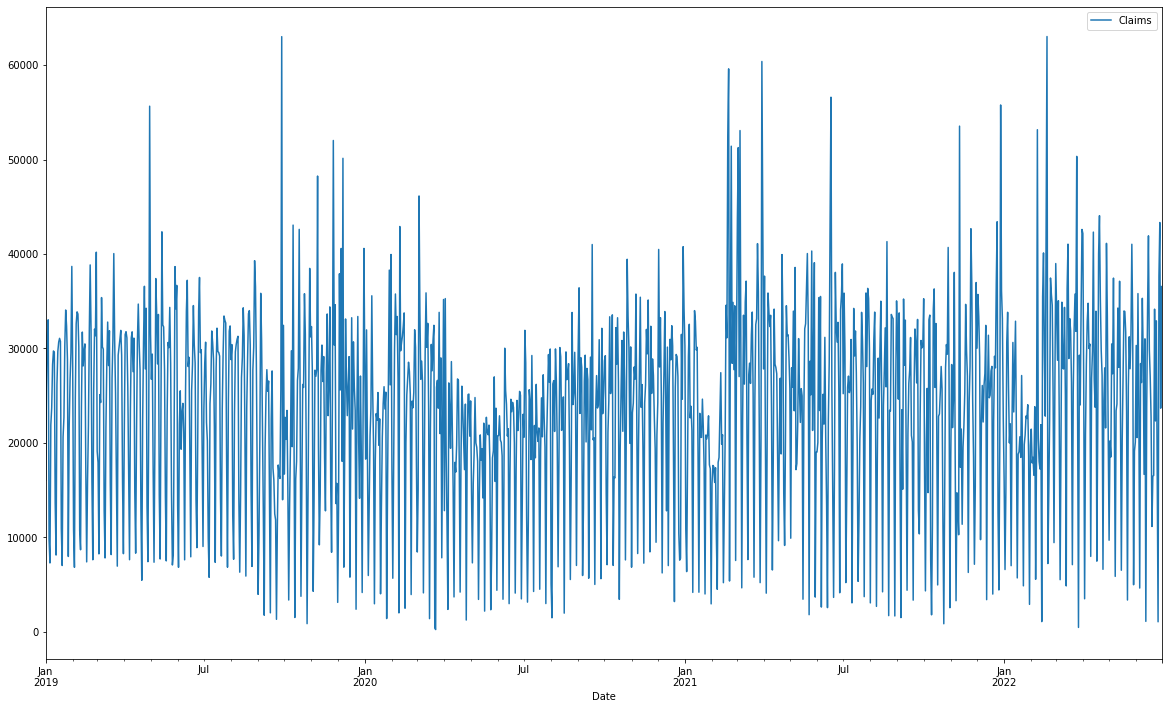

In [12]:
claims.plot(figsize=(20,12))

In [47]:
import statsmodels
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(claims['Claims'], period=12) 
plot_decompose(decomposition)
# decomposition.plot(figsize=(20,12));

NameError: name 'plot_decompose' is not defined

In [14]:
dec= seasonal_decompose(claims['Claims'])

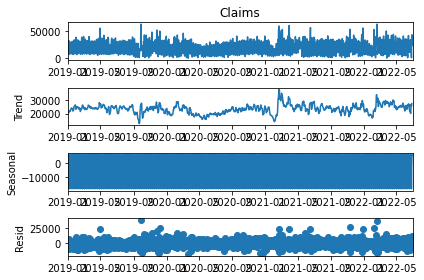

In [15]:
dec.plot();

In [16]:
train = claims.loc[:'2022-02-28']
test = claims.loc['2022-03-01':]

In [17]:
len(train)

1155

In [18]:
len(test)

122

In [19]:
scaler = MinMaxScaler()

In [20]:
scaler.fit(train)

MinMaxScaler()

In [21]:
scaled_train = scaler.transform(train)

In [22]:
scaled_test = scaler.transform(test) 

In [23]:
len(scaled_train)

1155

In [24]:
# define generator
n_input = 32
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=32
                               )

In [25]:
model = Sequential()

model.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value
model.compile(optimizer='adam', loss='mse')

2022-08-04 16:55:12.170924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-04 16:55:12.171171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-04 16:55:12.171309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-04 16:55:12.171444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-08-04 16:55:12.171597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 32, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 32, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [27]:
# fit model
model.fit(generator,epochs=350)

Epoch 1/350
36/36 [==============================] - 9s 119ms/step - loss: 0.0479
Epoch 2/350
36/36 [==============================] - 4s 112ms/step - loss: 0.0289
Epoch 3/350
36/36 [==============================] - 4s 112ms/step - loss: 0.0287
Epoch 4/350
36/36 [==============================] - 4s 111ms/step - loss: 0.0277
Epoch 5/350
36/36 [==============================] - 4s 107ms/step - loss: 0.0279
Epoch 6/350
36/36 [==============================] - 4s 112ms/step - loss: 0.0284
Epoch 7/350
36/36 [==============================] - 4s 110ms/step - loss: 0.0283
Epoch 8/350
36/36 [==============================] - 4s 110ms/step - loss: 0.0290
Epoch 9/350
36/36 [==============================] - 4s 105ms/step - loss: 0.0287
Epoch 10/350
36/36 [==============================] - 4s 107ms/step - loss: 0.0280
Epoch 11/350
36/36 [==============================] - 4s 104ms/step - loss: 0.0279
Epoch 12/350
36/36 [==============================] - 4s 108ms/step - loss: 0.0279
Epoch 13/350


36/36 [==============================] - 4s 98ms/step - loss: 0.0098
Epoch 197/350
36/36 [==============================] - 4s 102ms/step - loss: 0.0097
Epoch 198/350
36/36 [==============================] - 4s 102ms/step - loss: 0.0095
Epoch 199/350
36/36 [==============================] - 4s 107ms/step - loss: 0.0097
Epoch 200/350
36/36 [==============================] - 4s 102ms/step - loss: 0.0101
Epoch 201/350
36/36 [==============================] - 4s 103ms/step - loss: 0.0094
Epoch 202/350
36/36 [==============================] - 4s 104ms/step - loss: 0.0097
Epoch 203/350
36/36 [==============================] - 4s 103ms/step - loss: 0.0098
Epoch 204/350
36/36 [==============================] - 4s 102ms/step - loss: 0.0098
Epoch 205/350
36/36 [==============================] - 4s 102ms/step - loss: 0.0094
Epoch 206/350
36/36 [==============================] - 4s 101ms/step - loss: 0.0092
Epoch 207/350
36/36 [==============================] - 4s 102ms/step - loss: 0.0097
Epoch 2

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.

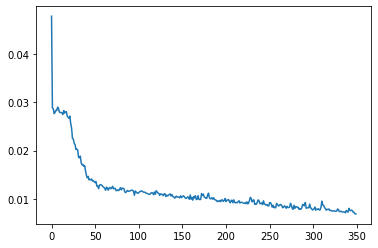

In [28]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [1]:
first_eval_batch = scaled_train[-32:]

NameError: name 'scaled_train' is not defined

In [30]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))

In [31]:
model.predict(first_eval_batch)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 1s 573ms/step


array([[0.4695971]], dtype=float32)

In [32]:
#holding my predictions
test_predictions = []


# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
# reshape this to the format RNN wants (same format as TimeseriesGeneration)
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#how far into the future will I forecast?

for i in range(len(test)):
    
    # One timestep ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    
    #store that prediction
    test_predictions.append(current_pred)
    
    # UPDATE current batch o include prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis= 1)

1/1 [==============================] - 0s 32ms/step


In [33]:
true_predictions = scaler.inverse_transform(test_predictions)

In [34]:
test['Predictions'] =true_predictions

/tmp/ipykernel_3130147/4217253912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] =true_predictions


In [35]:
test.tail(20)

,Claims,Predictions
Date,,
2022-06-11,31019,15795.710780
2022-06-12,1111,7626.745076
2022-06-13,23778,21215.415486
2022-06-14,34275,32462.522157
2022-06-15,41922,32732.500567
2022-06-16,29889,30929.639209
2022-06-17,27036,29225.129214
2022-06-18,22698,15813.063381
2022-06-19,11155,7716.855590


<AxesSubplot:xlabel='Date'>

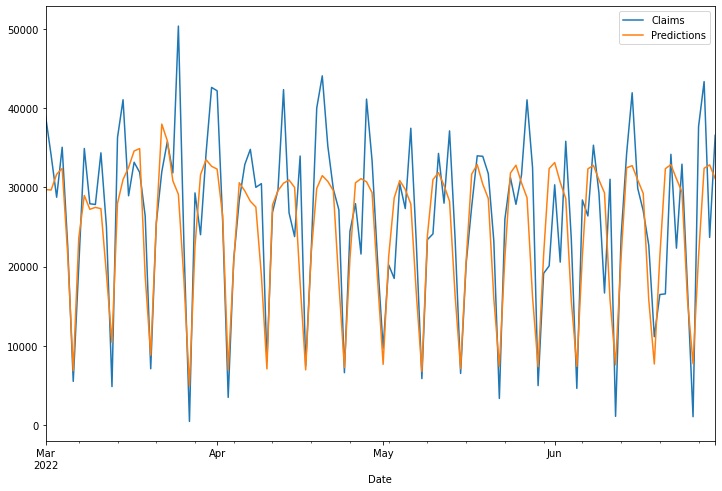

In [36]:
test.plot(figsize=(12,8))

In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Claims'],test['Predictions']))
print(rmse)

6803.123216718253


In [38]:
def calcsmape(actual, forecast):
    ytrue = np.array(actual)
    ypred = np.array(forecast)
    return np.mean(np.abs(ytrue - ypred) / ytrue) * 100

In [39]:
calcsmape(test['Claims'], test['Predictions'])

39.24109219557217